In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from connectivity.curves import CURVES


%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
n_replications = 12
BOOTSTRAP_RESULT_FILE = "../publish_data/paper/bootstrap_curve_analysis/bootstrap_curve_analysis_lf.json" # ""../publish_data/curve_fitting/curve_fitting.json"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json"
OUT_PATH = "../publish_data/paper/bootstrap_curve_analysis"

INCLUDE_REPLICATIONS_LIST = [9, 6, 5, 4, 3, 2, 1]
USE_CACHE = True

EXCLUDE_INTENSITIES_MATRICES = {
    17: [
        [],  # all intensities
        [1],
        [1, 3],
        [1, 3, 5],
        [1, 3, 5, 7],
        [1, 3, 5, 7, 12],
        [1, 3, 5, 7, 12, 14],
        [1, 3, 5, 7, 12, 14, 10],
        [1, 3, 5, 7, 12, 14, 10, 8],
        [1, 3, 5, 7, 12, 14, 10, 15],
        [1, 3, 5, 7, 12, 14, 10, 8, 15],
    ],
    # FIXME adapt to new matrix
    18: [
        [],  # all intensities
        [2],
        [2, 1],
        [2, 1, 4],
        [2, 1, 4, 6],
        [2, 1, 4, 6, 8],
        [2, 1, 4, 6, 8, 13],
        [2, 1, 4, 6, 8, 13, 15],
        [2, 1, 4, 6, 8, 13, 15, 11],
        [2, 1, 4, 6, 8, 13, 15, 11, 9],
        [2, 1, 4, 6, 8, 13, 15, 11, 16],
        [2, 1, 4, 6, 8, 13, 15, 11, 9, 16],
    ],
}
intensities = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 12.0])
CURVE = CURVES["5P"]
BOOTSTRAP_PERCENTILES = [2.5, 97.5]  #
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
bootstrap_df = pd.read_json(BOOTSTRAP_RESULT_FILE, orient="records")
responses_df = pd.read_json(RESPONSES_FILE, orient="records")

responses_df = responses_df[responses_df["patient_id"].isin(allowed_ids)]
bootstrap_df = pd.merge(
    responses_df,
    bootstrap_df,
    on=["patient_id", "stim_channel_name", "response_channel_name"],
    how="right"
)
bootstrap_df = bootstrap_df[bootstrap_df["patient_id"].isin(allowed_ids)]

c:\Users\E1024679\Documents\coherence\connectivity\curves.py:9: RuntimeWarning: overflow encountered in power
  denominator = (base) ** (1 / shape)


757


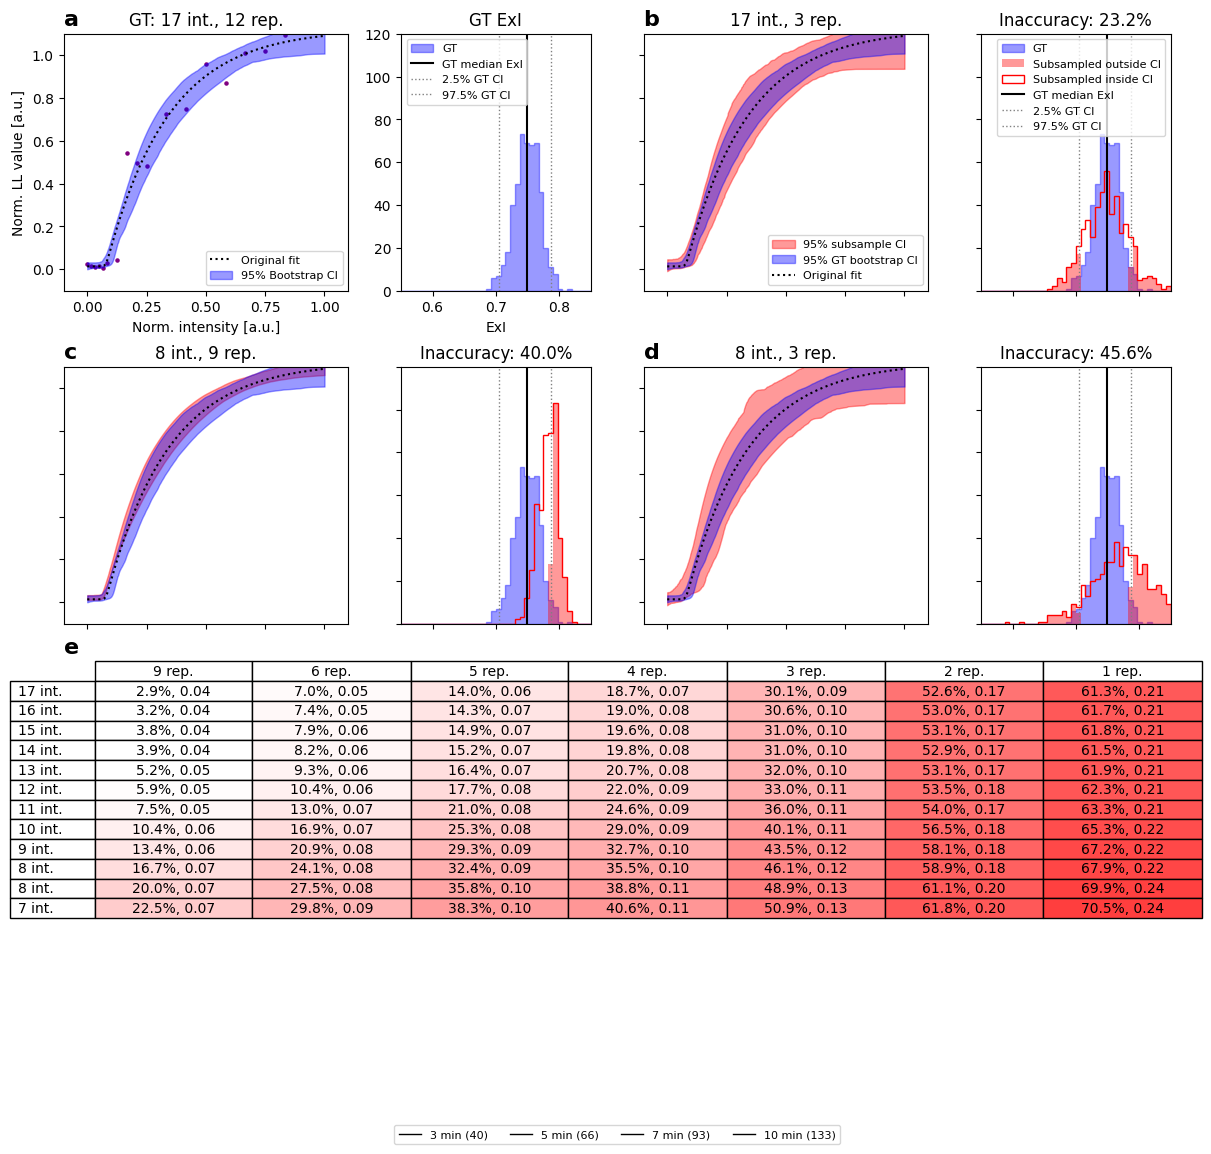

In [16]:
from connectivity.analyze import evaluate_bootstrap_result, fit_curve, normalize_ll_values
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

patient_id = "EL027"
stim_channel_name_pos = "A-L-3"
stim_channel_name_neg = "A-L-4"
stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

response_channel_name_pos = "aH-L-3"
response_channel_name_neg = "aH-L-4"
response_channel_name = response_channel_name_pos + "-" + response_channel_name_neg

pat_row = bootstrap_df[
    (bootstrap_df["patient_id"] == patient_id)
    & (bootstrap_df["stim_channel_name"] == stim_channel_name)
    & (bootstrap_df["response_channel_name"] == response_channel_name)
].squeeze()

norm_intensities = intensities / np.max(
    intensities
) 

shared_ll_min = np.nanmin(pat_row["med_lls"], axis=0)
shared_ll_max = np.nanpercentile(pat_row["med_lls"], 95, axis=0)
norm_ll_values = normalize_ll_values(
    ll_values=np.nanmedian(pat_row["ll_values"], axis=1),
    max=shared_ll_max,
    min=shared_ll_min,
    use_min=True,
    axis=0,
)
x_fit = np.linspace(
    min(norm_intensities),
    max(norm_intensities),
    1000,
)
try:
    params_original = fit_curve(
        curve_function=CURVE["function"],
        x=norm_intensities,
        y=norm_ll_values,
        initial_values=CURVE["initial_values"],
        bounds=CURVE["bounds"],
    )
    
except RuntimeError:
    print("Could not fit curve")


exclude_intensities_matrix = EXCLUDE_INTENSITIES_MATRICES.get(
    len(norm_intensities), None
)

x_fit = np.linspace(
    min(norm_intensities),
    max(norm_intensities),
    1000,
)
params_list_gt = np.load(
    f"{OUT_PATH}/params_list_{patient_id}_{stim_channel_name}_{response_channel_name}_gt.npz",
    allow_pickle=True,
)["params_list"]


ground_truth_result = evaluate_bootstrap_result(
    x_fit=x_fit,
    curve_function=CURVE["function"],
    params_list=params_list_gt,
    percentiles=BOOTSTRAP_PERCENTILES + [50],
)

def plot_ground_truth(ax_l, ax_r):
    ax_l.set_title(
        f"GT: {len(norm_intensities) - 1} int., {n_replications} rep."
    )
    ax_l.scatter(
        norm_intensities,
        norm_ll_values,
        s=5,
        color="purple",
    )
    y_fit_original = CURVE["function"](x_fit, *params_original)  # shape (1000,)
    ax_l.plot(
        x_fit,
        y_fit_original,
        label="Original fit",
        color="black",
        linestyle=":",
    )
    ax_l.fill_between(
        x_fit,
        ground_truth_result["percentiles"][0],
        ground_truth_result["percentiles"][1],
        color="blue",
        alpha=0.4,
        label=f"{round(BOOTSTRAP_PERCENTILES[1] - BOOTSTRAP_PERCENTILES[0])}% Bootstrap CI",
    )

    ax_l.set_ylim(-0.1, 1.1)
    ax_l.set_xlim(-0.1, 1.1)

    try:
        xmin, xmax = ax_r.get_xlim()
        bins = np.linspace(xmin, xmax, 41)
        ax_r.hist(
            ground_truth_result["aucs"], histtype="stepfilled", bins=bins, label="GT", edgecolor="blue", facecolor="blue", alpha=0.4
        )
    except:
        print("Histogram plotting error")
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][-1], #auc_original,
        color="black",
        label="GT median ExI",
    )
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][0],
        color="gray",
        linewidth=1,
        linestyle=":",
        label=f"{BOOTSTRAP_PERCENTILES[0]}% GT CI",
    )
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][1],
        color="gray",
        linewidth=1,
        linestyle=":",
        label=f"{BOOTSTRAP_PERCENTILES[1]}% GT CI",
    )
    ax_r.set_title("GT ExI")
    ax_r.set_ylim(top=60)  # FIXME


def plot_cell(ax_l, ax_r, reduced_intensity, reduced_replication):
    subset_params_matrix = np.load(
        f"{OUT_PATH}/params_list_{patient_id}_{stim_channel_name}_{response_channel_name}_subset_{reduced_intensity}.npz",
        allow_pickle=True,
    )["subset_params_matrix"]
    subset_params_list = subset_params_matrix[reduced_replication]
    subset_result = evaluate_bootstrap_result(
        x_fit=x_fit,
        curve_function=CURVE["function"],
        params_list=subset_params_list,
        percentiles=BOOTSTRAP_PERCENTILES,
    )  # shape (2, len(x_fit))

    # subset_ci = subset_percentiles[str(reduced_intensity)][str(reduced_replication)]
    y_fit_original = CURVE["function"](x_fit, *params_original)  # shape (1000,)
    ax_l.fill_between(
        x_fit,
        subset_result["percentiles"][0],
        subset_result["percentiles"][1],
        color="red",
        alpha=0.4,
        label=f"{round(BOOTSTRAP_PERCENTILES[1] - BOOTSTRAP_PERCENTILES[0])}% subsample CI",
    )
    ax_l.fill_between(
        x_fit,
        ground_truth_result["percentiles"][0],
        ground_truth_result["percentiles"][1],
        color="blue",
        alpha=0.4,
        label=f"{round(BOOTSTRAP_PERCENTILES[1] - BOOTSTRAP_PERCENTILES[0])}% GT bootstrap CI",
    )
    ax_l.plot(
        x_fit,
        y_fit_original,
        label="Original fit",
        color="black",
        linestyle=":",
    )
    ax_l.set_ylim(-0.1, 1.1)
    ax_l.set_xlim(-0.1, 1.1)
    ax_l.set_title(
        f"{len(norm_intensities) - len(exclude_intensities_matrix[reduced_intensity]) - 1} int., {INCLUDE_REPLICATIONS_LIST[reduced_replication]} rep."
    )
    try:
        xmin, xmax = ax_r.get_xlim()

        # fixed 30 bins over the whole range
        bins = np.linspace(xmin, xmax, 41)
        ax_r.hist(
            ground_truth_result["aucs"], histtype="stepfilled", bins=bins, label="GT", edgecolor="blue", facecolor="blue", alpha=0.4
        )
        low, high, med = ground_truth_result["auc_percentiles"]
        left_mask = (subset_result["aucs"] >= xmin) & (subset_result["aucs"] < low)
        mid_mask = (subset_result["aucs"] >= low) & (subset_result["aucs"] < high)
        right_mask = (subset_result["aucs"] >= high) & (subset_result["aucs"] <= xmax)
        # 1. red filled left side
        ax_r.hist(
            subset_result["aucs"][left_mask],
            bins=bins,
            color="red",
            alpha=0.4,
            label="Subsampled outside CI",
        )
        # 2. step middle
        ax_r.hist(
            subset_result["aucs"],
            bins=bins,
            histtype="step",
            color="red",
            linestyle="-",
            label="Subsampled inside CI"
        )
        # 3. red filled right side
        ax_r.hist(
            subset_result["aucs"][right_mask],
            bins=bins,
            color="red",
            alpha=0.4,
            label="_nolegend_",
        )
    except Exception as e:
        print("Histogram plotting error", e)
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][-1],
        color="black",
        label="GT median ExI",
    )
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][0],
        color="gray",
        linewidth=1,
        linestyle=":",
        label=f"{BOOTSTRAP_PERCENTILES[0]}% GT CI",
    )
    ax_r.axvline(
        x=ground_truth_result["auc_percentiles"][1],
        color="gray",
        linewidth=1,
        linestyle=":",
        label=f"{BOOTSTRAP_PERCENTILES[1]}% GT CI",
    )
    ax_r.set_title(
        f"Inaccuracy: {pat_row['misfit'][reduced_intensity][reduced_replication]:.1%}"
    )  
    ax_r.set_ylim(top=120) 



def plot_table(ax, metric_pair):
    metric_1_matrix = []
    metric_2_matrix = []
    print(len(bootstrap_df))
    for df_i, row_df in bootstrap_df.iterrows():
        values_1 = row_df[metric_pair[0]]
        values_2 = row_df[metric_pair[1]]
        if not np.all(np.isnan(np.atleast_1d(values_1))) and len(values_1) > 0:
            if metric_pair[0] == "relative_error":
                values_1 = np.abs(values_1)
            values_1 = np.array(values_1)
            if values_1.shape[0] == len(EXCLUDE_INTENSITIES_MATRICES[17]):
                # fix problem for EL019
                pad = np.full((1, values_1.shape[1]), np.nan)
                values_1 = np.vstack([pad, values_1])

            metric_1_matrix.append(values_1)
        else:
            metric_1_matrix.append(
                np.full(
                    (len(exclude_intensities_matrix), len(INCLUDE_REPLICATIONS_LIST)),
                    np.nan,
                )
            )
        if not np.all(np.isnan(np.atleast_1d(values_2))) and len(values_2) > 0:
            values_2 = np.array(values_2)
            if values_2.shape[0] == len(EXCLUDE_INTENSITIES_MATRICES[17]):
                # fix problem for EL019
                pad = np.full((1, values_2.shape[1]), np.nan)
                values_2 = np.vstack([pad, values_2])

            metric_2_matrix.append(values_2)
        else:
            metric_2_matrix.append(
                np.full(
                    (len(exclude_intensities_matrix), len(INCLUDE_REPLICATIONS_LIST)),
                    np.nan,
                )
            )
    metric_1_matrix = np.array(metric_1_matrix)
    metric_2_matrix = np.array(metric_2_matrix)

    mean_1_matrix = np.nanmean(metric_1_matrix, axis=0)
    mean_2_matrix = np.nanmean(metric_2_matrix, axis=0)
    color_matrix = mean_1_matrix
    formatted_matrix = [
        [f"{value:.1%}, {mean_2_matrix[i][j]:.2f}" for j, value in enumerate(row)]
        for i, row in enumerate(mean_1_matrix)
    ]
    table = ax.table(
        cellText=formatted_matrix,  # Content
        colLabels=[
            f"{n_rep} rep." for n_rep in INCLUDE_REPLICATIONS_LIST
        ],  # Column headers
        rowLabels=[
            f"{len(intensities) - len(exclude_intensities) - 1} int."
            for exclude_intensities in exclude_intensities_matrix
        ],  # Row headers
        loc="center",
        cellLoc="center",
        bbox=[0, 0, 1, 1],  # [left, bottom, width, height]
    )
    white_to_red = mcolors.LinearSegmentedColormap.from_list(
        "white_red", ["white", "red"]
    )

    thr = 0.05
    max_color_val = float(np.nanmax(color_matrix)) * 1.3

    norm = mcolors.Normalize(vmin=thr, vmax=max_color_val)

    for i in range(color_matrix.shape[0]):
        for j in range(color_matrix.shape[1]):
            value = color_matrix[i, j]
            color = white_to_red(norm(value))  # Get color from colormap
            table[i + 1, j].set_facecolor(color)  # +1 because row headers exist

    table.auto_set_column_width(col=list(range(len(INCLUDE_REPLICATIONS_LIST))))

    ax.axis("off")

    labels  = ["3 min (40)", "5 min (66)", "7 min (93)", "10 min (133)"]
    linestyles = ["-", "-", "-", "-"]
    colors = ["black", "black", "black", "black"]  # or use the same color as the table borders

    # build handles with the same thickness as the table borders
    handles = [
        Line2D([0], [0], linestyle=ls, color=c, linewidth=1)
        for ls, c in zip(linestyles, colors)
    ]
    ax.legend(
        handles, labels, fontsize=8,
        loc="lower center", bbox_to_anchor=(0.5, -0.90), ncol=4
    )


fig = plt.figure(figsize=(12, 14), constrained_layout=True)
gs = GridSpec(
    4,
    4,
    figure=fig,
    width_ratios=[1.5, 1, 1.5, 1],  # height_ratios=[2, 2]
)

ax_al = fig.add_subplot(gs[0, 0])
ax_al.set_title("a", loc="left", fontsize=16, fontweight="bold")
ax_ar = fig.add_subplot(gs[0, 1])
ax_ar.set_xlim([0.55, 0.85])
plot_ground_truth(ax_l=ax_al, ax_r=ax_ar)
ax_al.set_xlabel("Norm. intensity [a.u.]")
ax_al.set_ylabel("Norm. LL value [a.u.]")
ax_al.legend(fontsize=8)
ax_ar.legend(fontsize=8)
ax_ar.set_xlabel("ExI")

ax_bl = fig.add_subplot(gs[0, 2], sharey=ax_al)
ax_bl.set_title("b", loc="left", fontsize=16, fontweight="bold")
ax_br = fig.add_subplot(gs[0, 3], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_bl, ax_r=ax_br, reduced_intensity=0, reduced_replication=4)
ax_bl.legend(fontsize=8)
ax_br.legend(fontsize=8)
plt.setp(ax_bl.get_yticklabels(), visible=False)
plt.setp(ax_bl.get_xticklabels(), visible=False)
plt.setp(ax_br.get_yticklabels(), visible=False)
plt.setp(ax_br.get_xticklabels(), visible=False)

ax_cl = fig.add_subplot(gs[1, 0], sharey=ax_al)
ax_cl.set_title("c", loc="left", fontsize=16, fontweight="bold")
ax_cr = fig.add_subplot(gs[1, 1], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_cl, ax_r=ax_cr, reduced_intensity=10, reduced_replication=0)
plt.setp(ax_cl.get_yticklabels(), visible=False)
plt.setp(ax_cl.get_xticklabels(), visible=False)
plt.setp(ax_cr.get_yticklabels(), visible=False)
plt.setp(ax_cr.get_xticklabels(), visible=False)

ax_dl = fig.add_subplot(gs[1, 2], sharey=ax_al)
ax_dl.set_title("d", loc="left", fontsize=16, fontweight="bold")
ax_dr = fig.add_subplot(gs[1, 3], sharey=ax_ar, sharex=ax_ar)
plot_cell(ax_l=ax_dl, ax_r=ax_dr, reduced_intensity=10, reduced_replication=4)
plt.setp(ax_dl.get_yticklabels(), visible=False)
plt.setp(ax_dl.get_xticklabels(), visible=False)
plt.setp(ax_dr.get_yticklabels(), visible=False)
plt.setp(ax_dr.get_xticklabels(), visible=False)

ax_t2 = fig.add_subplot(gs[2, :])
ax_t2.set_title("e", loc="left", fontsize=16, fontweight="bold")
plot_table(
    ax=ax_t2, metric_pair=["misfit", "delta_auc"]
)

#plt.savefig("../output/figures/figure3.pdf", bbox_inches="tight", dpi=300)
plt.savefig("../output/figures/figure3.svg", bbox_inches="tight", dpi=300)
plt.show()

In [17]:
## GT confidence intervals across participants
import os

auc_percentiles_diffs = []
auc_percentiles_diffs_r_squared_thres = []

for df_i, row_df in bootstrap_df.iterrows():
    pat_id = row_df["patient_id"]
    stim_ch_name = row_df["stim_channel_name"]
    response_ch_name = row_df["response_channel_name"]

    path = f"{OUT_PATH}/params_list_{pat_id}_{stim_ch_name}_{response_ch_name}_gt.npz"
    if os.path.exists(path):
        params_list_gt = np.load(
            path,
            allow_pickle=True,
        )["params_list"]
    else:
        print("File not found:", path)


    ground_truth_result = evaluate_bootstrap_result(
        x_fit=x_fit,
        curve_function=CURVE["function"],
        params_list=params_list_gt,
        percentiles=BOOTSTRAP_PERCENTILES + [50],
    )

    # auc percentiles:
    auc_percentiles_diff = ground_truth_result["auc_percentiles"][1] - ground_truth_result["auc_percentiles"][0]
    auc_percentiles_diffs.append(auc_percentiles_diff)

    ground_truth_result = evaluate_bootstrap_result(
        x_fit=x_fit,
        curve_function=CURVE["function"],
        params_list=params_list_gt,
        percentiles=BOOTSTRAP_PERCENTILES + [50],
        r_squared_threshold=0.6,
        x_dp=norm_intensities,
        y_dp_true=pat_row["norm_med_lls"],
    )
    if isinstance(ground_truth_result["auc_percentiles"], (list, np.ndarray)):
        auc_percentiles_diffs_r_squared_thres.append(ground_truth_result["auc_percentiles"][1] - ground_truth_result["auc_percentiles"][0])
    else:
        print("No percentiles", path)
    #print(ground_truth_result)




File not found: ../publish_data/paper/bootstrap_curve_analysis/params_list_EL020_L-BTa-1-L-BTa-2_L-A-10-L-A-11_gt.npz
File not found: ../publish_data/paper/bootstrap_curve_analysis/params_list_EL026_aH-L-5-aH-L-6_pI-L-6-pI-L-7_gt.npz


c:\Users\E1024679\Documents\coherence\.venv\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1619: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL026_aH-L-1-aH-L-2_AML-L-3-AML-L-4_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL026_aH-L-1-aH-L-2_aH-L-4-aH-L-5_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL028_OF-R-1-OF-R-2_aI-R-5-aI-R-6_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL027_aH-L-3-aH-L-4_pH-L-4-pH-L-5_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL027_aH-L-3-aH-L-4_pH-L-5-pH-L-6_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL027_aH-L-3-aH-L-4_pH-L-6-pH-L-7_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL027_A-L-3-A-L-4_aI-L-9-aI-L-10_gt.npz
No percentiles ../publish_data/paper/bootstrap_curve_analysis/params_list_EL027_OF-L-11-OF-L-12_A-R-8-A-R-9_gt.npz


In [18]:
print(np.mean(auc_percentiles_diffs), np.std(auc_percentiles_diffs))
print(f"{np.mean(auc_percentiles_diffs):.2f}$\\pm${np.std(auc_percentiles_diffs):.2f}")
print(np.mean(auc_percentiles_diffs_r_squared_thres), np.std(auc_percentiles_diffs_r_squared_thres))

0.1483791065229976 0.09884045407459548
0.15$\pm$0.10
0.13215195299766067 0.07525705039699945
